In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Execute VAR

### 1.1. Load data

In [15]:
df_newspaper_index = pd.read_csv("database/newspaper_index.csv")
df_realized_volatility = pd.read_csv("database/realized_volatility.csv")

#### Note that:
- df_newspaper_index ranges from **1991-04 to 2023-10**
- df_realized_volatility ranges from **1986-01 to 2023-08**

### 1.2. Create a combined dataframe *df_var*

In [16]:
# Merge the two dataframes on the "month" column
df_var = pd.merge(df_newspaper_index, df_realized_volatility, on="month", how="inner", suffixes=('_newspaper', '_volatility'))

# Rename the columns to match your requirements
df_var.rename(columns={'value_newspaper': 'newspaper_index', 'value_volatility': 'realized_volatility'}, inplace=True)

# Since you want the months starting from 1991-04 to 2023-10, you may need to filter the dataframe
df_var = df_var[(df_var['month'] >= '1991-04') & (df_var['month'] <= '2023-10')]

# Reset the index of the dataframe
df_var.reset_index(drop=True, inplace=True)

# Now df_var should have the columns "month", "newspaper_index", and "realized_volatility" as desired

df_var

,month,newspaper_index,realized_volatility
0,1991-04,32.740904,26.416435
1,1991-05,33.814744,20.218068
2,1991-06,54.761893,17.695459
3,1991-07,47.457754,19.773372
4,1991-08,36.631362,27.700901
...,...,...,...
384,2023-04,94.000128,34.055352
385,2023-05,36.450292,39.179082
386,2023-06,78.708933,37.050846
387,2023-07,29.934583,24.476116


### 1.3. Check stationarity

In [17]:
# Function to perform ADF test on a series
def adf_test(series):
    result = adfuller(series, autolag='AIC')  # AIC will choose the best lag for us
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [18]:
# Convert "month" to datetime and set as index
df_var['month'] = pd.to_datetime(df_var['month'])
df_var.set_index('month', inplace=True)

# Select only the columns for VAR
df_var_for_analysis = df_var[['newspaper_index', 'realized_volatility']]

In [19]:
print("newspaper_index")
adf_test(df_var_for_analysis['newspaper_index'])
print()
print("realized_volatility")
adf_test(df_var_for_analysis['realized_volatility'])

newspaper_index
ADF Statistic: -2.776037
p-value: 0.061779
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571

realized_volatility
ADF Statistic: -15.698150
p-value: 0.000000
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


In [20]:
# Differencing the series to make it stationary
df_var_for_analysis['newspaper_index_diff'] = df_var_for_analysis['newspaper_index'].diff().dropna()

# Performing ADF test on the differenced series
print("Differenced newspaper_index")
adf_test(df_var_for_analysis['newspaper_index_diff'][1:])  # exclude the first NaN value after differencing

Differenced newspaper_index
ADF Statistic: -8.983290
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


In [21]:
df_var_for_analysis = df_var_for_analysis.iloc[1:]
df_var_for_analysis = df_var_for_analysis[["newspaper_index_diff","realized_volatility"]]

### 1.4. Check correlation

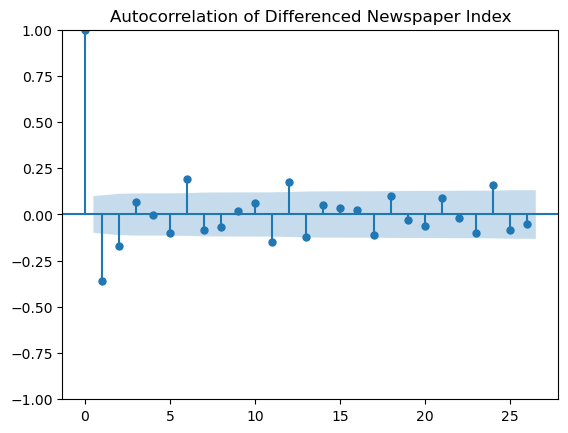

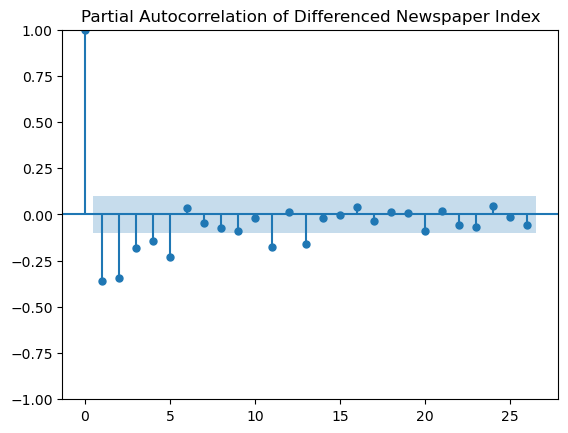

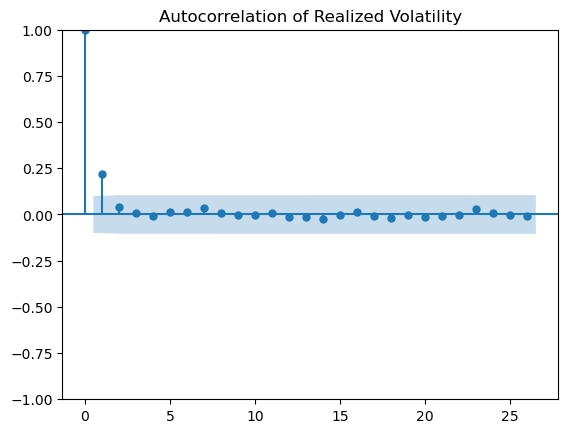

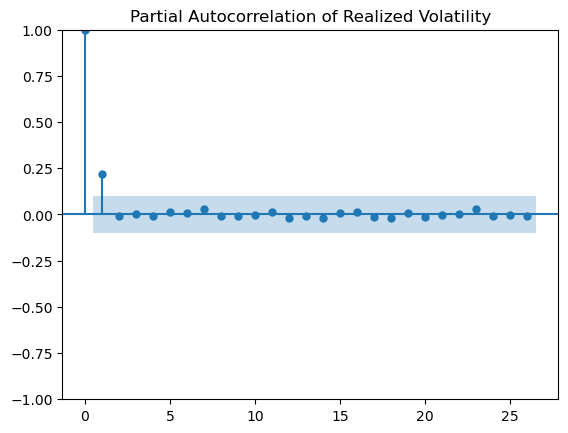

/var/folders/kw/6hnl881s2p9701b42gpjt_pr0000gn/T/ipykernel_13001/1218961298.py:22: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  ccf_values = ccf(df_var_for_analysis['newspaper_index_diff'], df_var_for_analysis['realized_volatility'], unbiased=True)


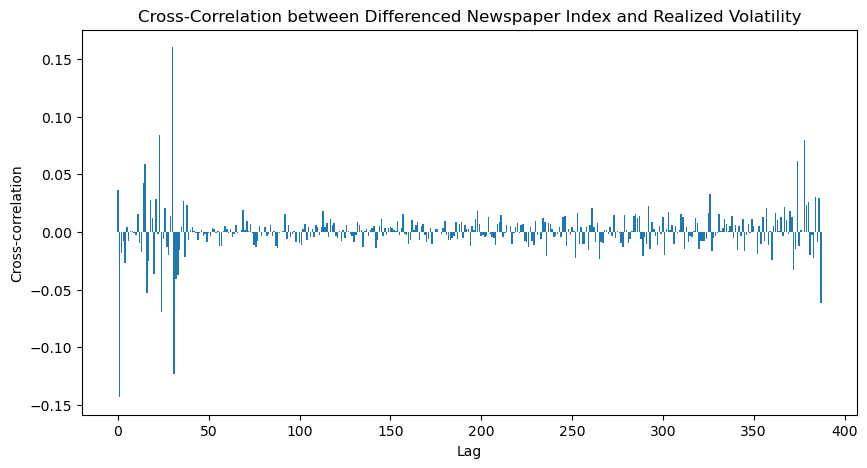

In [22]:
# Plot autocorrelation for newspaper_index_diff
plot_acf(df_var_for_analysis['newspaper_index_diff'])
plt.title('Autocorrelation of Differenced Newspaper Index')
plt.show()

# Plot partial autocorrelation for newspaper_index_diff
plot_pacf(df_var_for_analysis['newspaper_index_diff'])
plt.title('Partial Autocorrelation of Differenced Newspaper Index')
plt.show()

# Plot autocorrelation for realized_volatility
plot_acf(df_var_for_analysis['realized_volatility'])
plt.title('Autocorrelation of Realized Volatility')
plt.show()

# Plot partial autocorrelation for realized_volatility
plot_pacf(df_var_for_analysis['realized_volatility'])
plt.title('Partial Autocorrelation of Realized Volatility')
plt.show()

# Plot cross-correlation between newspaper_index_diff and realized_volatility
ccf_values = ccf(df_var_for_analysis['newspaper_index_diff'], df_var_for_analysis['realized_volatility'], unbiased=True)

plt.figure(figsize=(10, 5))
lags = range(len(ccf_values))
plt.bar(lags, ccf_values)
plt.title('Cross-Correlation between Differenced Newspaper Index and Realized Volatility')
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.show()


### 1.5. Conduct VAR (4 lags)

In [23]:
# Fit the VAR model with 4 lags
model = VAR(df_var_for_analysis)
results = model.fit(4)

# Summary of the model
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 09, Nov, 2023
Time:                     22:45:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    17.4740
Nobs:                     384.000    HQIC:                   17.3623
Log likelihood:          -4391.20    FPE:                3.22440e+07
AIC:                      17.2888    Det(Omega_mle):     3.07841e+07
--------------------------------------------------------------------
Results for equation newspaper_index_diff
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          11.867853         6.002367            1.977           0.048
L1.newspaper_index_diff        -0.577330         0.051420          -11.228           0.000
L1.re

/Users/minwukim/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### 1.5. Conduct AIC test

In [24]:
# Select only the columns for VAR
df_var_for_analysis = df_var[['newspaper_index', 'realized_volatility']]

# Initialize the VAR model
model = VAR(df_var_for_analysis)

# Select the optimal lag order with AIC
lag_order_results = model.select_order(maxlags=15)
print(lag_order_results.summary())

# The optimal number of lags based on AIC
optimal_lags = lag_order_results.aic

# Fit the VAR model with the optimal number of lags
results = model.fit(optimal_lags)

# Summary of the model with the optimal lags
print(results.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        17.54       17.56   4.159e+07       17.55
1        17.28      17.34*   3.186e+07      17.30*
2        17.28       17.39   3.201e+07       17.32
3       17.26*       17.41  3.135e+07*       17.32
4        17.27       17.46   3.169e+07       17.35
5        17.29       17.52   3.214e+07       17.38
6        17.27       17.54   3.161e+07       17.38
7        17.28       17.60   3.200e+07       17.41
8        17.30       17.66   3.268e+07       17.44
9        17.32       17.72   3.330e+07       17.48
10       17.34       17.78   3.390e+07       17.51
11       17.36       17.84   3.461e+07       17.55
12       17.35       17.88   3.443e+07       17.56
13       17.37       17.94   3.505e+07       17.60
14       17.37       17.98   3.507e+07       17.61
15       17.39       18.04   3.559e+07       17.65
-------------------------------

/Users/minwukim/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### 1.6 Impulse Response Function

/Users/minwukim/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


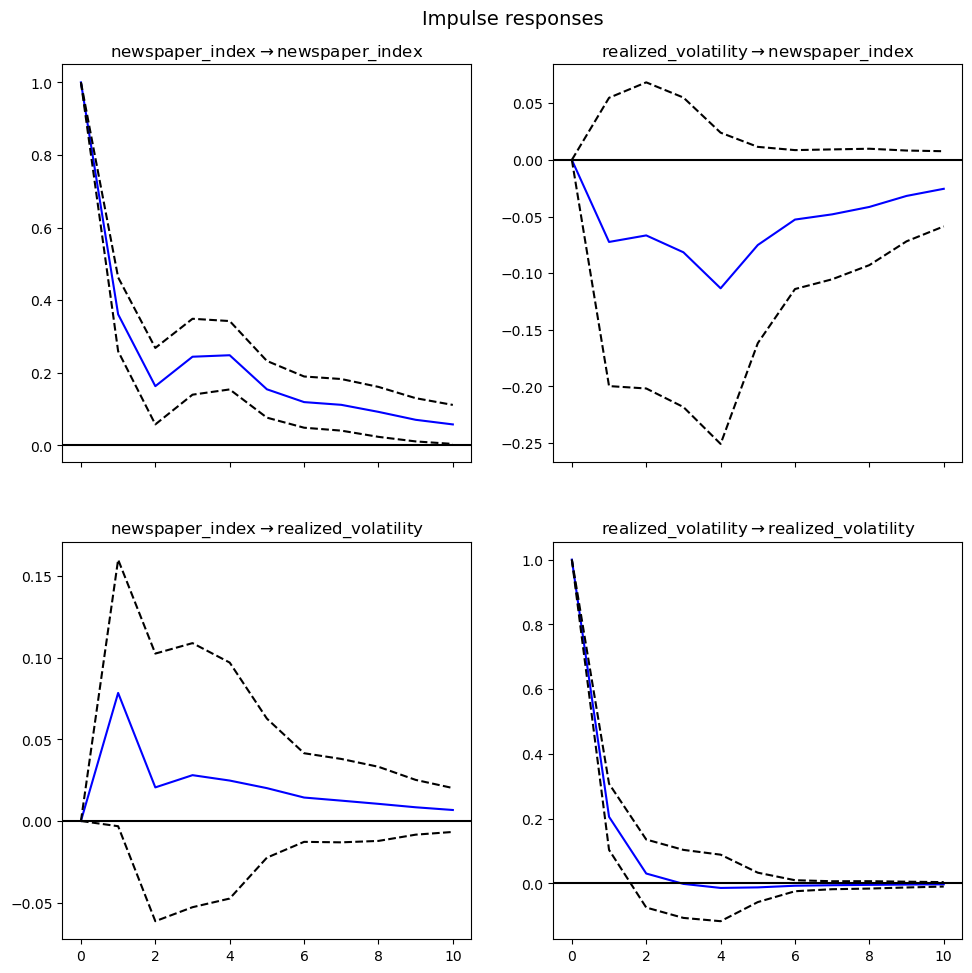

In [28]:
# Fit the VAR model with 4 lags
model = VAR(df_var[['newspaper_index', 'realized_volatility']])
results = model.fit(4)

# Obtain the standard deviation of the residuals for the 'newspaper_index'
std_newspaper_index = results.resid['newspaper_index'].std()

# Compute the impulse response function for 10 periods
irf = results.irf(periods=10)

# Plot the impulse response of 'newspaper_index' to the shock
irf.plot(orth=False)  # Set orth=False for generalized IRF
plt.show()

# # To plot the response of 'realized_volatility' to the shock in 'newspaper_index' specifically
# # We access the impulse response directly from the irf object
# # Assuming 'realized_volatility' is the second variable in the VAR model
# plt.plot(irf.irfs[:, 1, 0])  # The second index is for 'realized_volatility', the third index is for 'newspaper_index' shock
# plt.title('Response of Realized Volatility to a One-SD Shock in Newspaper Index')
# plt.xlabel('Periods')
# plt.ylabel('Response')
# plt.show()
